# Step 3: Train and predict

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import BooleanType, DateType, FloatType, IntegerType, LongType

In [2]:
# Spark Session
spark = SparkSession.builder.appName('Fraud-Detector').getOrCreate()

22/01/24 19:10:02 WARN Utils: Your hostname, francesc-Inspiron-5570 resolves to a loopback address: 127.0.1.1; using 192.168.1.141 instead (on interface wlp3s0)
22/01/24 19:10:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/01/24 19:10:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/24 19:10:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# Read datasets
df_train = spark.read.csv('data/clean_fraudTrain.csv', header=True)
df_test = spark.read.csv('data/clean_fraudTest.csv', header=True)

In [4]:
# Show Pretty Data
df_train.limit(5).toPandas()

,timestamp,credit_card_num,shop,category,amount,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,age
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0,31
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0,41
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,42.1808,-112.262,4154,Nature conservation officer,43.150704,-112.154481,0,57
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.0,M,46.2306,-112.1138,1939,Patent attorney,47.034331,-112.561071,0,52
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,38.4207,-79.4629,99,Dance movement psychotherapist,38.674999,-78.632459,0,33


In [5]:
# Cast Data
df_train.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- credit_card_num: string (nullable = true)
 |-- shop: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- city_pop: string (nullable = true)
 |-- job: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- age: string (nullable = true)



**We have to cast all the data because the csv, don't have meta-data that indicates the type.**

In [6]:
def cast_df(df):
    df = df.withColumn("credit_card_num", df.credit_card_num.cast(LongType()))
    df = df.withColumn("amount", df.amount.cast(FloatType()))
    df = df.withColumn("lat", df.lat.cast(FloatType()))
    df = df.withColumn("long", df.long.cast(FloatType()))
    df = df.withColumn("city_pop", df.city_pop.cast(IntegerType()))
    df = df.withColumn("merch_lat", df.merch_lat.cast(FloatType()))
    df = df.withColumn("merch_long", df.merch_long.cast(FloatType()))
    df = df.withColumn("is_fraud", df.is_fraud.cast(IntegerType()))
    df = df.withColumn("age", df.age.cast(IntegerType()))
    return df

In [7]:
# Cast
df_train = cast_df(df_train)
df_test = cast_df(df_test)

In [8]:
# Drop
df_train = df_train.drop("timestamp")
df_test = df_test.drop("timestamp")

In [9]:
# Encode Categorical Variables
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml import Pipeline

cat_col = ['shop', 'category', 'gender', 'job']

list_string_indexer = [StringIndexer(inputCol=c, outputCol=c + "_indexed") for c in cat_col]
ppl = Pipeline(stages=list_string_indexer)

df_train_indexed = ppl.fit(df_train).transform(df_train).drop(*cat_col)
df_test_indexed = ppl.fit(df_test).transform(df_test).drop(*cat_col)

**We have to encode string variables to int, because the algorithm/s that we will use don't support strings.** 

In [10]:
df_train_indexed.limit(5).toPandas()

,credit_card_num,amount,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,shop_indexed,category_indexed,gender_indexed,job_indexed
0,2703186189652095,4.970000,36.078800,-81.178101,3495,36.011292,-82.048317,0,31,571.0,11.0,0.0,141.0
1,630423337322,107.230003,48.887798,-118.210503,149,49.159046,-118.186462,0,41,81.0,1.0,0.0,61.0
2,38859492057661,220.110001,42.180801,-112.262001,4154,43.150703,-112.154480,0,57,319.0,6.0,1.0,457.0
3,3534093764340240,45.000000,46.230598,-112.113800,1939,47.034332,-112.561073,0,52,40.0,0.0,1.0,232.0
4,375534208663984,41.959999,38.420700,-79.462898,99,38.674999,-78.632462,0,33,519.0,10.0,1.0,297.0


In [11]:
from pyspark.ml.feature import VectorAssembler

numericCols = ['credit_card_num', 'amount', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age',
               'gender_indexed', 'category_indexed', 'shop_indexed', 'job_indexed']
assembler = VectorAssembler(inputCols=numericCols, outputCol="features")

df_train_indexed = assembler.transform(df_train_indexed)
df_test_indexed = assembler.transform(df_test_indexed)

In [12]:
df_test_indexed.limit(5).toPandas()

,credit_card_num,amount,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,shop_indexed,category_indexed,gender_indexed,job_indexed,features
0,2291163933867244,2.860000,33.965900,-80.935501,333497,33.986389,-81.200714,0,52,469.0,7.0,1.0,40.0,"[2291163933867244.0, 2.859999895095825, 33.965..."
1,3573030041201292,29.840000,40.320702,-110.435997,302,39.450497,-109.960434,0,30,386.0,7.0,0.0,33.0,"[3573030041201292.0, 29.84000015258789, 40.320..."
2,3598215285024754,41.279999,40.672901,-73.536499,34496,40.495811,-74.196114,0,50,440.0,9.0,0.0,28.0,"[3598215285024754.0, 41.279998779296875, 40.67..."
3,3591919803438423,60.049999,28.569700,-80.819099,54767,28.812399,-80.883064,0,33,500.0,10.0,1.0,328.0,"[3591919803438423.0, 60.04999923706055, 28.569..."
4,3526826139003047,3.190000,44.252899,-85.016998,1126,44.959148,-85.884735,0,65,641.0,13.0,1.0,258.0,"[3526826139003047.0, 3.190000057220459, 44.252..."


In [13]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="is_fraud", featuresCol="features", numTrees=5,maxBins=693)
model = rf.fit(df_train_indexed)

In [14]:
# Make Predictions
predictions = model.transform(df_test_indexed)

In [15]:
predictions.limit(10).toPandas()

,credit_card_num,amount,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,shop_indexed,category_indexed,gender_indexed,job_indexed,features,rawPrediction,probability,prediction
0,2291163933867244,2.860000,33.965900,-80.935501,333497,33.986389,-81.200714,0,52,469.0,7.0,1.0,40.0,"[2291163933867244.0, 2.859999895095825, 33.965...","[4.990902289632468, 0.009097710367531162]","[0.9981804579264937, 0.0018195420735062323]",0.0
1,3573030041201292,29.840000,40.320702,-110.435997,302,39.450497,-109.960434,0,30,386.0,7.0,0.0,33.0,"[3573030041201292.0, 29.84000015258789, 40.320...","[4.990481121112927, 0.009518878887073458]","[0.9980962242225854, 0.0019037757774146916]",0.0
2,3598215285024754,41.279999,40.672901,-73.536499,34496,40.495811,-74.196114,0,50,440.0,9.0,0.0,28.0,"[3598215285024754.0, 41.279998779296875, 40.67...","[4.990481121112927, 0.009518878887073458]","[0.9980962242225854, 0.0019037757774146916]",0.0
3,3591919803438423,60.049999,28.569700,-80.819099,54767,28.812399,-80.883064,0,33,500.0,10.0,1.0,328.0,"[3591919803438423.0, 60.04999923706055, 28.569...","[4.987914027039023, 0.012085972960976282]","[0.9975828054078046, 0.0024171945921952565]",0.0
4,3526826139003047,3.190000,44.252899,-85.016998,1126,44.959148,-85.884735,0,65,641.0,13.0,1.0,258.0,"[3526826139003047.0, 3.190000057220459, 44.252...","[4.988335195558566, 0.011664804441433986]","[0.9976670391117132, 0.0023329608882867972]",0.0
5,30407675418785,19.549999,42.193901,-76.736099,520,41.747158,-77.584198,0,29,214.0,4.0,0.0,275.0,"[30407675418785.0, 19.549999237060547, 42.1939...","[4.987567545498942, 0.012432454501057314]","[0.9975135090997884, 0.0024864909002114627]",0.0
6,213180742685905,133.929993,40.507000,-123.974297,1139,41.499458,-124.888725,0,69,494.0,9.0,0.0,68.0,"[213180742685905.0, 133.92999267578125, 40.506...","[4.992474774626026, 0.007525225373973828]","[0.9984949549252052, 0.0015050450747947654]",0.0
7,3589289942931264,10.370000,43.755699,-97.593597,343,44.495499,-97.728455,0,48,379.0,7.0,0.0,154.0,"[3589289942931264.0, 10.369999885559082, 43.75...","[4.98300679791194, 0.01699320208805977]","[0.9966013595823882, 0.0033986404176119546]",0.0
8,3596357274378601,4.370000,41.000099,-78.235703,3688,41.546066,-78.120239,0,47,237.0,3.0,1.0,232.0,"[3596357274378601.0, 4.369999885559082, 41.000...","[4.992263456844962, 0.007736543155037658]","[0.9984526913689924, 0.0015473086310075317]",0.0
9,3546897637165774,66.540001,31.659100,-96.809402,263,31.782919,-96.366188,0,64,422.0,8.0,0.0,23.0,"[3546897637165774.0, 66.54000091552734, 31.659...","[4.992474774626026, 0.007525225373973828]","[0.9984949549252052, 0.0015050450747947654]",0.0


# Metrics and evaluation

In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.9963128847493068
Test Error = 0.003687115250693207


In [17]:
# Metrics
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.evaluation.MulticlassMetrics.html

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
import pyspark.sql.functions as F

preds_and_labels = predictions.select(['prediction', 'is_fraud']).withColumn('is_fraud', F.col('is_fraud').cast(
    FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction', 'is_fraud'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))


In [18]:
# Confusion Matrix
conf_matrix = metrics.confusionMatrix().toArray()

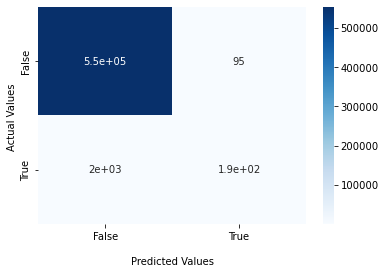

In [19]:
import seaborn as sns

ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [20]:
# Decode Labels
list_index_string = [IndexToString(inputCol=c + "_indexed", outputCol=c) for c in cat_col]
ppl = Pipeline(stages=list_index_string)

df_train_decoded = ppl.fit(df_train_indexed).transform(df_train_indexed).drop(
    *['shop_indexed', 'gender_indexed', 'job_indexed', 'features'])
df_test_decoded = ppl.fit(predictions).transform(predictions).drop(
    *['shop_indexed', 'gender_indexed', 'job_indexed', 'features', 'rawPrediction', 'probability'])

In [21]:
df_test_decoded.filter(df_test_decoded.is_fraud != df_test_decoded.prediction).toPandas()

,credit_card_num,amount,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,category_indexed,prediction,shop,category,gender,job
0,4302480582202074,981.919983,43.232601,-86.249199,128715,43.849102,-85.560455,0,25,5.0,1.0,"fraud_Towne, Greenholt and Koepp",shopping_net,M,Historic buildings inspector/conservation officer
1,3560725013359375,24.840000,31.859900,-102.741302,23,32.575874,-102.604286,1,51,9.0,0.0,fraud_Hamill-D'Amore,health_fitness,F,Cytogeneticist
2,6564459919350820,780.520020,42.554501,-90.350800,1306,42.461128,-91.147148,1,62,11.0,0.0,"fraud_Rodriguez, Yost and Jenkins",misc_net,M,Public relations officer
3,6564459919350820,620.330017,42.554501,-90.350800,1306,42.771835,-90.158363,1,62,6.0,0.0,fraud_Nienow PLC,entertainment,M,Public relations officer
4,4005676619255478,1077.689941,30.459000,-90.902702,71335,31.204973,-90.261597,1,26,5.0,0.0,"fraud_Heathcote, Yost and Kertzmann",shopping_net,M,Herbalist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044,3514865930894695,705.400024,32.939602,-105.818901,899,33.706383,-106.110672,0,53,5.0,1.0,fraud_Auer-West,shopping_net,M,Naval architect
2045,2657850734909997,978.340027,42.374901,-83.108704,673342,42.682968,-82.207062,0,74,5.0,1.0,fraud_Cormier LLC,shopping_net,M,Trading standards officer
2046,3512365128314616,830.280029,38.430500,-90.387001,35439,38.184570,-89.951416,0,36,5.0,1.0,fraud_Terry-Huel,shopping_net,M,Land/geomatics surveyor
2047,30143535920989,1299.310059,39.801601,-75.347801,504,38.966503,-75.922890,0,40,3.0,1.0,"fraud_Okuneva, Schneider and Rau",shopping_pos,F,"Engineer, control and instrumentation"


In [22]:
df_test_decoded.filter(df_test_decoded.is_fraud == 1).filter(df_test_decoded.prediction == 0).toPandas()

,credit_card_num,amount,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,category_indexed,prediction,shop,category,gender,job
0,3560725013359375,24.840000,31.859900,-102.741302,23,32.575874,-102.604286,1,51,9.0,0.0,fraud_Hamill-D'Amore,health_fitness,F,Cytogeneticist
1,6564459919350820,780.520020,42.554501,-90.350800,1306,42.461128,-91.147148,1,62,11.0,0.0,"fraud_Rodriguez, Yost and Jenkins",misc_net,M,Public relations officer
2,6564459919350820,620.330017,42.554501,-90.350800,1306,42.771835,-90.158363,1,62,6.0,0.0,fraud_Nienow PLC,entertainment,M,Public relations officer
3,4005676619255478,1077.689941,30.459000,-90.902702,71335,31.204973,-90.261597,1,26,5.0,0.0,"fraud_Heathcote, Yost and Kertzmann",shopping_net,M,Herbalist
4,3560725013359375,842.650024,31.859900,-102.741302,23,31.315783,-102.736389,1,51,3.0,0.0,fraud_Hermann and Sons,shopping_pos,F,Cytogeneticist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1949,2242176657877538,997.770020,34.632301,-89.885498,14462,35.112480,-90.417068,1,62,5.0,0.0,fraud_Predovic Inc,shopping_net,M,Database administrator
1950,2242176657877538,1041.510010,34.632301,-89.885498,14462,34.573471,-89.911011,1,62,3.0,0.0,"fraud_Willms, Kris and Bergnaum",shopping_pos,M,Database administrator
1951,2242176657877538,868.090027,34.632301,-89.885498,14462,34.091228,-90.390610,1,62,3.0,0.0,fraud_Kuhn LLC,shopping_pos,M,Database administrator
1952,2242176657877538,289.269989,34.632301,-89.885498,14462,34.746063,-90.401093,1,62,1.0,0.0,fraud_Bauch-Raynor,grocery_pos,M,Database administrator


In [23]:
df_test_decoded.filter(df_test_decoded.is_fraud == 0).filter(df_test_decoded.prediction == 1).toPandas()

,credit_card_num,amount,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,category_indexed,prediction,shop,category,gender,job
0,4302480582202074,981.919983,43.232601,-86.249199,128715,43.849102,-85.560455,0,25,5.0,1.0,"fraud_Towne, Greenholt and Koepp",shopping_net,M,Historic buildings inspector/conservation officer
1,4839615922685395,1008.940002,39.013000,-86.545700,76,39.814629,-86.387260,0,65,5.0,1.0,"fraud_Romaguera, Cruickshank and Greenholt",shopping_net,M,Social researcher
2,3526826139003047,937.080017,44.252899,-85.016998,1126,44.882168,-85.633446,0,65,11.0,1.0,fraud_Kunde-Sanford,misc_net,M,Furniture designer
3,375248307838179,711.760010,38.856400,-80.157997,571,39.119247,-80.773521,0,53,5.0,1.0,fraud_Hills-Witting,shopping_net,M,Accounting technician
4,4410582919485061752,1085.270020,32.369701,-81.361801,9034,32.670418,-82.195694,0,51,5.0,1.0,fraud_Volkman-Predovic,shopping_net,M,"Therapist, occupational"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,3514865930894695,705.400024,32.939602,-105.818901,899,33.706383,-106.110672,0,53,5.0,1.0,fraud_Auer-West,shopping_net,M,Naval architect
91,2657850734909997,978.340027,42.374901,-83.108704,673342,42.682968,-82.207062,0,74,5.0,1.0,fraud_Cormier LLC,shopping_net,M,Trading standards officer
92,3512365128314616,830.280029,38.430500,-90.387001,35439,38.184570,-89.951416,0,36,5.0,1.0,fraud_Terry-Huel,shopping_net,M,Land/geomatics surveyor
93,30143535920989,1299.310059,39.801601,-75.347801,504,38.966503,-75.922890,0,40,3.0,1.0,"fraud_Okuneva, Schneider and Rau",shopping_pos,F,"Engineer, control and instrumentation"


# Conclusions
As we can see in the results of the metrics performed, we can see that we have a little more than 99% of accuracity, this indicates that we rarely fail to perform a perdition. First of all, we thought that we had some problem in the solution of the problem since it is difficult to obtain this value. After reviewing the code in detail and thinking about what could cause this high percentage, we realized the following:

- We have a dataset where we use 70% of the values for training and 30% for testing.
- Within this data set, we have the unbalanced target variable, where 99.42% are legit transactions.
- We have very few cases of fraudulent transactions.
- Most of our classifier will be based on detecting patterns of correct purchases and not fraudulent purchases.

Therefore, if we understand all the characteristics that compose this dataset, we will understand that the value is correct. It is because around 99% of the generated purchases are made legitly, therefore we understand that it is common and that only a few cases will be fraudulent. This means that our algorithm will study the purchase patterns according to a large percentage of legit purchases, thus making some false positives. For this reason we miss around 1.700 transactions saying that is legit when in fact is fraud. Therefore, the accuracy is given by the high volume of hones transactions and the correct decteted.